##### Figure 4cdef

# HRRR and MesoWest Cumulative Distribution

Every 6 hours

- MesoWest percentile calculations retreived from MesoWest API  
- HRRR percentile calculations generated by the OSG

In [29]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new

In [32]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.2
twothird_column = 5.5
mpl.rcParams['figure.figsize'] = [one_column, 2.8]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


## Get lat/lon grid from file to pluck point from HRRR OSG dataset

In [33]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

### Get a point from the OSG percentile grid

In [34]:
def get_point_percentiles(DATE):
    ## PP stands for Percentiles Point
    if DATE.day == 1 and DATE.hour == 0:
        print 'Working on', DATE
    
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    PP = np.array([])
    with h5py.File(DIR+FILE, 'r') as f:
        for i in percentiles:
            PP = np.append(PP, f["p%02d" % i][x][y])
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        PP -= 273.15
    
    return PP

-------

### Input Arguments
statistic can be from the list:  
`mean, p00, p01, p02, p03, p04, p05, p10, p15, p25, p33, p50, p66, p75, p90, p95, p96, p97, p98, p99, p100`

In [35]:
percentiles = [0, 1, 2, 3, 4, 5, 10, 25, 33, 50, 66, 75, 90, 95, 96, 97, 98, 99, 100]
var = 'UVGRD:10 m'
stn = 'HWKC1'
fxx = 0

# Date of interest
leapyear = 2016
DATE = datetime(leapyear, 10, 9)

# Hours
hours = [0, 6, 12, 18]

##### Additional Setup

In [96]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

if var == 'TMP:2 m':
    MWvar = 'air_temp'
    label = '2 m Temperature (C)'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
    label = '2 m Dew Point Temperature (C)'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
    label = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
    MWlabel = r'Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
    label = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
else:
    MWvar = ''
    print "NO MATCHING VAR AND MESOWEST VAR"

## Get HRRR Percentiles
From the OSG files

In [37]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

PP = {}
for i in hours:
    DATETIME = datetime(leapyear, DATE.month, DATE.day, i)
    PP[i] = get_point_percentiles(DATETIME)

## Get MesoWest Percentiles
From MesoWest API

In [38]:
MW_PDF = {}
for h in hours:
    DATETIME = datetime(leapyear, DATE.month, DATE.day, h)
    start = DATETIME.strftime('%m%d%H')
    end = start

    MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles='ALL')
    
    MW_pdf = []
    for i in percentiles:
        MW_pdf.append(MW_per['p%02d'%i][0])
    
    MW_PDF[h] = MW_pdf

## HRRR vs MesoWest

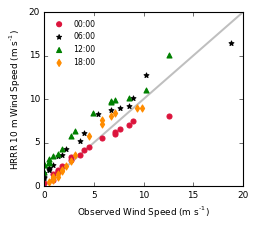

In [111]:
C = ['crimson', 'black', 'green', 'darkorange']
M = ['o', '*', '^', 'd']

plt.plot(range(21),range(21), color=[.75,.75,.75], zorder=1)

# MesoWest CD vs HRRR CD
for i, hour in enumerate(hours):
    plt.scatter(MW_PDF[hour], PP[hour],
             color=C[i],
             marker=M[i],
             label='%02d:00' % hour,
             zorder=2)

    
plt.xlabel('Observed %s' % (MWlabel))
plt.ylabel('HRRR %s' % (label))
plt.ylim([0,20])
plt.xlim([0,20])

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

legend = plt.gca().legend(frameon=True, framealpha=.8, loc=2, scatterpoints=1)
legend.get_frame().set_linewidth(0)
plt.savefig('./figs/Fig_04c_CD_compare_%s_%s_%s' % (stn.upper(), variable, DATE.strftime('m%m_d%d_h00-h06-h12-h18')))

---
## Create Figure -- 3 Pannel

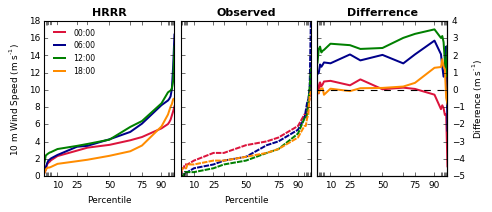

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=[two_column, 2.5])

C = ['crimson', 'darkblue', 'green', 'darkorange']


# --- Plot HRRR Percentile Curve -------------------------------
plt.sca(ax1)
for i, hour in enumerate(hours):
    plt.plot(percentiles, PP[hour],
             color=C[i],
             label='%02d:00' % hour)

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel('%s' % (label))

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

legend = plt.gca().legend(frameon=True, framealpha=.8, loc=2)
legend.get_frame().set_linewidth(0)
    
plt.title('HRRR', fontweight='semibold')



# --- Plot MesoWest PDF -----------------------------------------
plt.sca(ax2)
for i, hour in enumerate(hours):
    plt.plot(percentiles, MW_PDF[hour],
             color=C[i],
             label='%02d:00' % hour,
             linestyle='--', dashes=(5, 1))

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

    
plt.title('Observed', fontweight='semibold')


# --- Plot PDF Difference ---------------------------------------
ax3b = ax3.twinx()
plt.sca(ax3b)
for i, hour in enumerate(hours):
    plt.plot(percentiles, PP[hour]-MW_PDF[hour],
             color=C[i],
             label='%02d:00' % hour)

plt.axhline(0, c='k', linewidth=1, linestyle='--')
    

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(r'Difference %s' % label[label.find('('):])

   
plt.title('Differrence', fontweight='semibold')


plt.savefig('./figs/Fig_04c_CD_3pannel_%s_%s_%s' % (stn.upper(), variable, DATE.strftime('m%m_d%d_h00-h06-h12-h18')))

## Alternative Figure

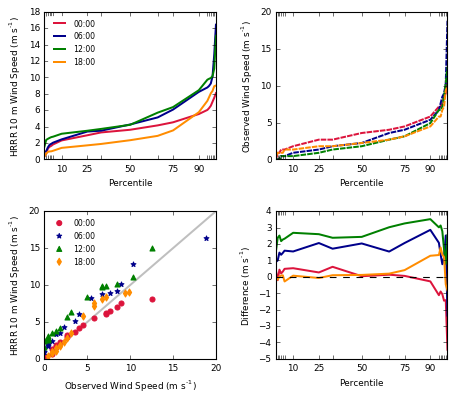

In [97]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=False, figsize=[two_column, 2.8*2])


# --- Plot HRRR Percentile Curve -------------------------------
plt.sca(ax1)
for i, hour in enumerate(hours):
    plt.plot(percentiles, PP[hour],
             color=C[i],
             label='%02d:00' % hour)

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel('HRRR %s' % (label))

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

legend = plt.gca().legend(frameon=True, framealpha=.8, loc=2)
legend.get_frame().set_linewidth(0)
    
#plt.title('HRRR', fontweight='semibold')



# --- Plot MesoWest PDF -----------------------------------------
plt.sca(ax2)
for i, hour in enumerate(hours):
    plt.plot(percentiles, MW_PDF[hour],
             color=C[i],
             label='%02d:00' % hour,
             linestyle='--', dashes=(5, 1))

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel('Observed %s' % (MWlabel))

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

    
#plt.title('Observed', fontweight='semibold')

# Correlation between HRRR and MesoWest Cumulative Distribution
plt.sca(ax3)
plt.plot(range(21),range(21), color=[.75,.75,.75], zorder=1)

C = ['crimson', 'darkblue', 'green', 'darkorange']
M = ['o', '*', '^', 'd']

# MesoWest CD vs HRRR CD
for i, hour in enumerate(hours):
    plt.scatter(MW_PDF[hour], PP[hour],
             color=C[i],
             marker=M[i],
             label='%02d:00' % hour,
             zorder=2)

    
plt.xlabel('Observed %s' % (MWlabel))
plt.ylabel('HRRR %s' % (label))
plt.ylim([0,20])
plt.xlim([0,20])

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

legend = plt.gca().legend(frameon=True, framealpha=.8, loc=2, scatterpoints=1)
legend.get_frame().set_linewidth(0)


# Difference
plt.sca(ax4)
for i, hour in enumerate(hours):
    plt.plot(percentiles, PP[hour]-MW_PDF[hour],
             color=C[i],
             label='%02d:00' % hour)

plt.axhline(0, c='k', linewidth=1, linestyle='--')
    

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(r'Difference %s' % label[label.find('('):])


plt.subplots_adjust(wspace=.35,hspace=.35)

plt.savefig('./figs/Fig_04_alternative_CD_correlation')

## Print difference across HRRR and MesoWest Cumulative Distribution ranks

In [93]:
print 'Difference across all ranks'
for i, hour in enumerate(hours):
    print '    %02d:00 UTC Mean Difference:\t %s' % (hour, np.mean(PP[hour]-MW_PDF[hour]))

Difference across all ranks
    00:00 UTC Mean Difference:	 -0.390736842105
    06:00 UTC Mean Difference:	 1.42742105263
    12:00 UTC Mean Difference:	 2.47615789474
    18:00 UTC Mean Difference:	 0.324105263158


In [95]:
print 'Difference for 50th percentile'
for i, hour in enumerate(hours):
    print '    %02d:00 UTC p50 Difference:\t %s' % (hour, (PP[hour]-MW_PDF[hour])[8])

Difference for 50th percentile
    00:00 UTC p50 Difference:	 0.61
    06:00 UTC p50 Difference:	 1.713
    12:00 UTC p50 Difference:	 2.378
    18:00 UTC p50 Difference:	 0.097
